# **Tutorial for Xenium analysis with python.**


#### **Load Xenium as anndata format**
##### **The AnnData is designed for handling single-cell (transcriptomics) or multi-modal (transcriptomics and spatial information) data.**<br>

##### .obs:   Metadata related to observations (usually cells or genes)
##### .var:   Metadata related to variables(genes)
##### .obsm: Additional information associated with observation
##### .varm: Additional information associated with variabs
##### .obsp: Store sparse binary or boolean connectivity matrices between cells in a single-cell RNA sequencing (scRNA-seq) dataset 
##### .uns:   User-defined additional information (Unstructured data, ex: Colors)

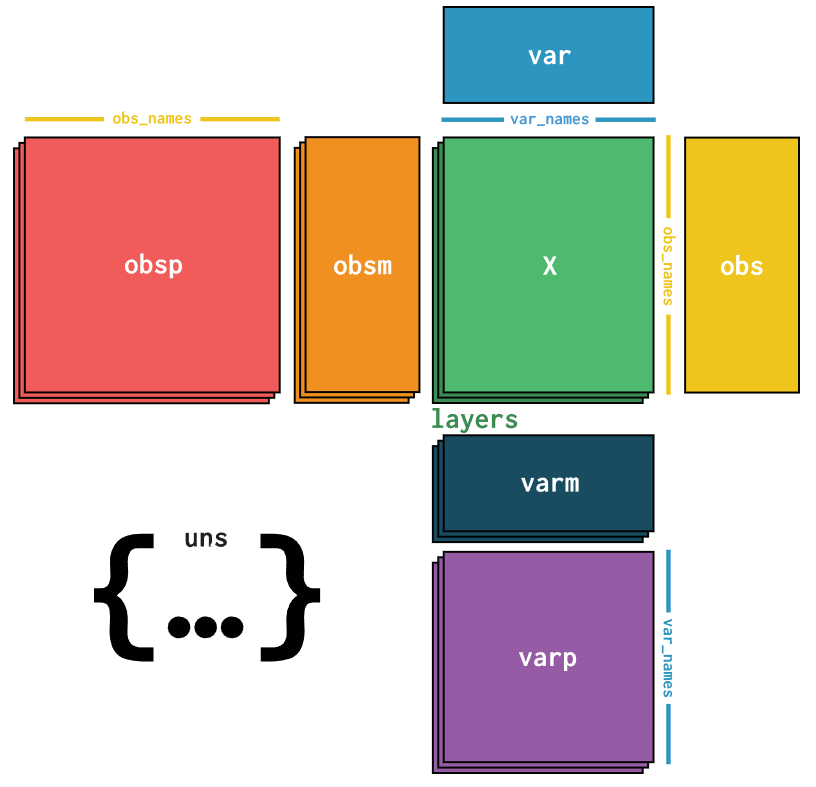

In [3]:
Image("D:/Projects/Xenium/figs/Anndata.png)

In [16]:
# Import modules
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#### **1.How to load a single xenium data**

In [2]:
adata = sc.read_10x_h5(filename="D:/Projects/Xenium/data/0007534_g04_02r_c/cell_feature_matrix.h5")
df = pd.read_csv("D:/Projects/Xenium/data/0007534_g04_02r_c/cells.csv.gz")

df.set_index(adata.obs_names, inplace=True)
adata.obs = df.copy()
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [11]:
print(adata)

AnnData object with n_obs × n_vars = 36642 × 366
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'


In [12]:
print(adata.obs)

               cell_id   x_centroid   y_centroid  transcript_counts  \
aaabijfn-1  aaabijfn-1   850.019040  1231.159528                132   
aaablbao-1  aaablbao-1   830.244919   985.832117                 95   
aaaehkjo-1  aaaehkjo-1   821.165109   986.599213                 70   
aaaeopnk-1  aaaeopnk-1   837.718579  1348.786578                 76   
aaakipni-1  aaakipni-1   821.329309  1349.472534                 70   
...                ...          ...          ...                ...   
oidlhnhi-1  oidlhnhi-1  5152.299072  1538.673694                137   
oidphkce-1  oidphkce-1  5003.473950  1532.712592                126   
oieckgik-1  oieckgik-1  5106.227246  1536.994031                322   
oiedillc-1  oiedillc-1  5127.534106  1541.781299                 48   
oiedofpm-1  oiedofpm-1  5060.579175  1537.967609                 62   

            control_probe_counts  control_codeword_counts  \
aaabijfn-1                     0                        0   
aaablbao-1               

In [8]:
print(adata.X.shape)

(36642, 366)


#### **2.Check data quality**

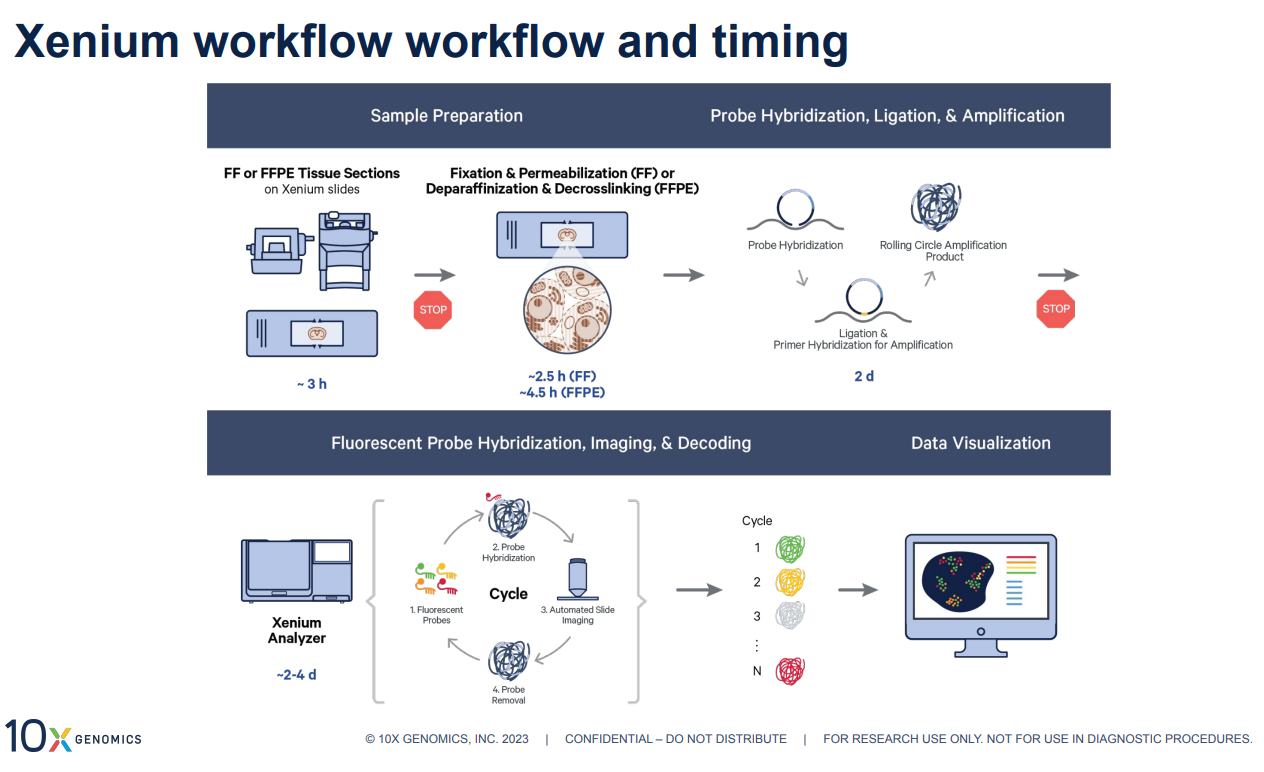

In [14]:
Image("D:/Projects/Xenium/figs/0.png")

In [9]:
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

cprobes = (adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100)
cwords = (adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

Negative DNA probe count % : 0.007374569578293494
Negative decoding count % : 0.002355459536947474


##### 1) Control Probes:<br><br>Control probes are synthetic or natural DNA or RNA sequences that are deliberately introduced into an experiment to serve as internal controls.<br>These probes are not part of the primary experimental samples but are added to monitor various aspects of the experiment's performance.<br><br>

##### 2) Control Codewords:<br><br>Specific sequences of symbols or markers that represent specific genes.<br>In this context, codewords are likely a series of attributes related to fluorescent signal intensities, recorded across various channels and cycles.<br.<br>


#### **3.Filter cells**

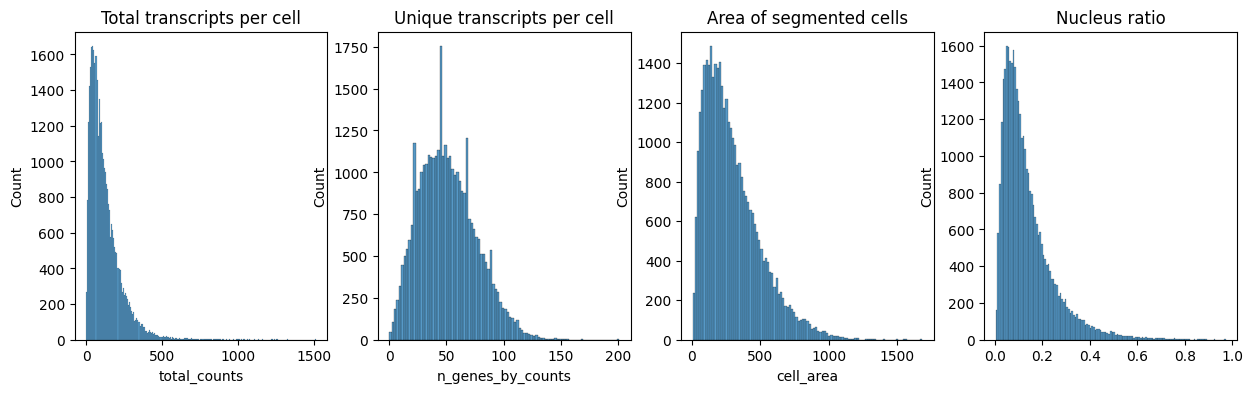

In [15]:
# Plot distribution of total transcripts per cell
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
axs[1].set_title("Unique transcripts per cell")
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, ax=axs[1])
axs[2].set_title("Area of segmented cells")
sns.histplot(adata.obs["cell_area"], kde=False, ax=axs[2])
axs[3].set_title("Nucleus ratio")
sns.histplot(adata.obs["nucleus_area"] / adata.obs["cell_area"], kde=False, ax=axs[3])
plt.show()


In [17]:
# %% Filter cell and genes
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)

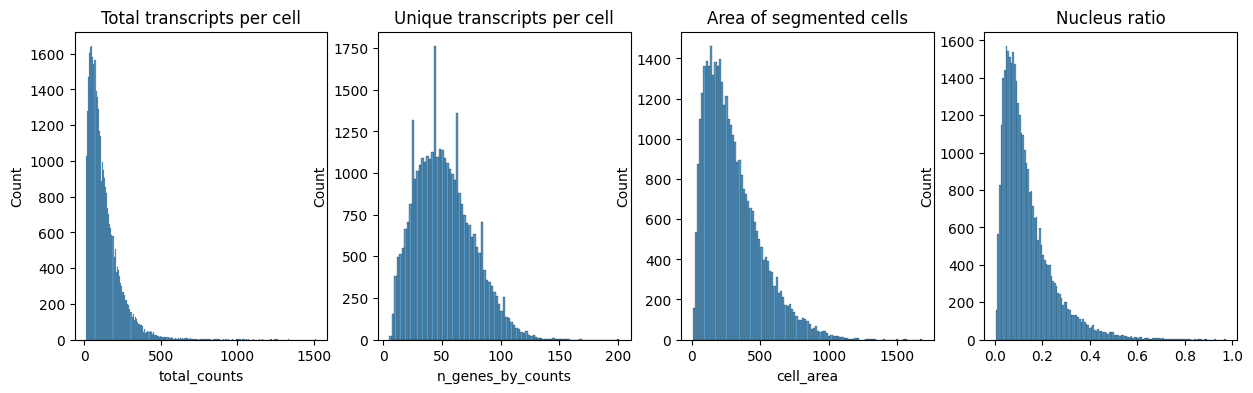

In [18]:
# Plot distribution of total transcripts per cell
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
axs[1].set_title("Unique transcripts per cell")
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, ax=axs[1])
axs[2].set_title("Area of segmented cells")
sns.histplot(adata.obs["cell_area"], kde=False, ax=axs[2])
axs[3].set_title("Nucleus ratio")
sns.histplot(adata.obs["nucleus_area"] / adata.obs["cell_area"], kde=False, ax=axs[3])
plt.show()

In [19]:
print(adata.X.shape)

(36095, 366)


#### **4. Pre-processing**

In [20]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

C:\Users\jocke\Anaconda3\envs\Xenium\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


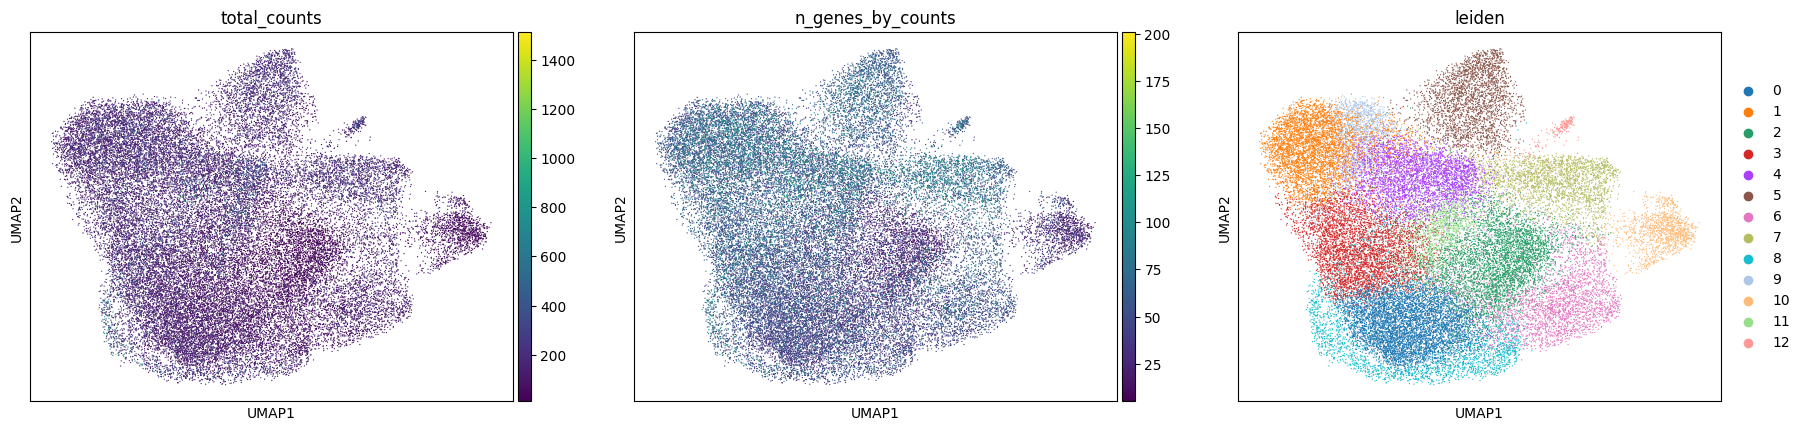

In [21]:
# Visulaize annotation on UMAP
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "leiden"])

C:\Users\jocke\Anaconda3\envs\Xenium\lib\site-packages\squidpy\pl\_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


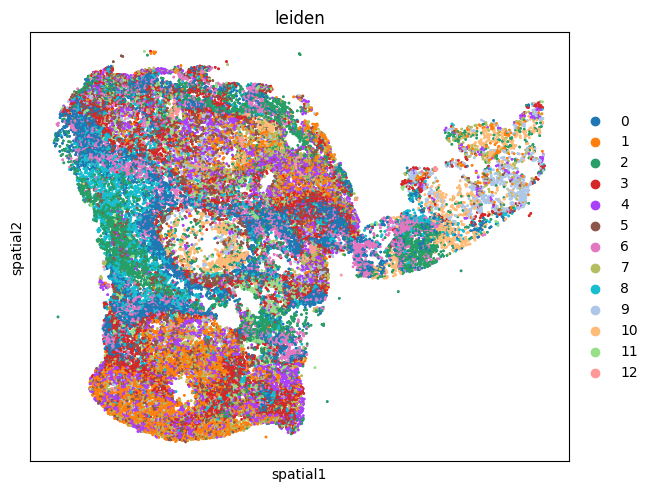

In [22]:
# Visulaize annotation on UMAP and spatial coordinates
sq.pl.spatial_scatter(adata, library_id="spatial", shape=None, color=["leiden"], wspace=0.4)
plt.show()

#### **5. Cell Type assignment**

In [24]:
# %% Check common_marker_genes and meta genes
df_ref_panel_ini = pd.read_excel("D:/Projects/Xenium/data/Xenium_HumanBrainPanel_GeneList_removed_double_columns.xlsx", index_col=0)
# df_ref_panel_ini = pd.read_csv('/home/ext_choi_yoonho_mayo_edu/jupyter/Reference.csv', index_col=0)
print(df_ref_panel_ini.head(5))


               Ensembl ID Annotation
Gene                                
ABCC9     ENSG00000069431       VLMC
ADAMTS12  ENSG00000151388       VLMC
ADAMTS16  ENSG00000145536      L4 IT
ADAMTS3   ENSG00000156140      L6 IT
ADRA1A    ENSG00000120907       Sncg


In [25]:
df_ref_panel = df_ref_panel_ini.iloc[1:, 1:] # Check 'Annotation' column
df_ref_panel.index.name = None
df_ref_panel.columns = ["Function"]
marker_genes = df_ref_panel["Function"].index.tolist()

print(df_ref_panel.head(5))
print(marker_genes)

         Function
ADAMTS12     VLMC
ADAMTS16    L4 IT
ADAMTS3     L6 IT
ADRA1A       Sncg
ADRA1B       Sncg
['ADAMTS12', 'ADAMTS16', 'ADAMTS3', 'ADRA1A', 'ADRA1B', 'AIF1', 'ALK', 'ANGPT1', 'ANK1', 'ANKRD18A', 'ANO3', 'ANXA1', 'APOE', 'APP', 'AQP4', 'ARHGAP24', 'ATP2C2', 'B4GALNT1', 'BCAN', 'BRINP3', 'BTBD11', 'C1QL3', 'C1orf162', 'CALCRL', 'CAPG', 'CAPN3', 'CAV1', 'CCK', 'CCL4', 'CCL5', 'CCNA1', 'CCNB2', 'CD14', 'CD163', 'CD2', 'CD36', 'CD3G', 'CD4', 'CD48', 'CD52', 'CD68', 'CD83', 'CD86', 'CDH1', 'CDH12', 'CDH4', 'CDH6', 'CDK1', 'CEMIP', 'CEMIP2', 'CENPF', 'CHODL', 'CLDN11', 'CNDP1', 'CNTN2', 'CNTNAP3B', 'COL12A1', 'COL25A1', 'CORO1A', 'CRHBP', 'CRYM', 'CSPG4', 'CTNNA3', 'CTSH', 'CTSS', 'CUX2', 'CX3CR1', 'CXCL14', 'CXCR4', 'CYTIP', 'DCN', 'DDR2', 'DNER', 'EFHD1', 'EGFR', 'ELOVL2', 'ERBB3', 'ERMN', 'EYA4', 'FASLG', 'FBLN1', 'FCER1G', 'FCGR1A', 'FCGR3A', 'FGFR2', 'FGFR3', 'FILIP1', 'FLT1', 'FSTL4', 'GAD1', 'GAD2', 'GAS2L3', 'GJA1', 'GNLY', 'GPNMB', 'GPR183', 'GPR34', 'GZMA', 'HES1', 'HH

In [26]:
# Get common_marker_genes between data and ref_panel
from copy import deepcopy
meta_gene = deepcopy(adata.var)
common_marker_genes = list(set(meta_gene.index.tolist()).intersection(marker_genes))
meta_gene.loc[common_marker_genes, "Markers"] = df_ref_panel.loc[common_marker_genes, "Function"]
meta_gene["Markers"].value_counts()

Markers
Immune             54
Tumor              34
Other              18
VLMC               17
L6 IT Car3         11
Microglia-PVM      10
Oligodendrocyte     9
Chandelier          9
Pax6                9
OPC                 9
Lamp5 Lhx6          8
Endothelial         8
Sst Chodl           8
Astrocyte           7
Pvalb               7
L5/6 NP             7
L4 IT               6
Sncg                5
L5 ET               5
Sst                 4
L6 CT               4
L2/3 IT             3
Lamp5               3
L6 IT               3
L6b                 3
L5 IT               2
Vip                 2
LAB                 1
Name: count, dtype: int64

In [29]:
# Calculate Leiden Cluster Average Expression Signatures
ser_counts = adata.obs["leiden"].value_counts()
ser_counts.name = "cell counts"
meta_leiden = pd.DataFrame(ser_counts)
cat_name = "leiden"
sig_leiden = pd.DataFrame(columns=adata.var_names, index=adata.obs[cat_name].cat.categories)
for clust in adata.obs[cat_name].cat.categories:
    sig_leiden.loc[clust] = adata[adata.obs[cat_name].isin([clust]), :].X.mean(0)
sig_leiden = sig_leiden.transpose()
leiden_clusters = ["Leiden-" + str(x) for x in sig_leiden.columns.tolist()]
sig_leiden.columns = leiden_clusters
meta_leiden.index = sig_leiden.columns.tolist()
meta_leiden["leiden"] = pd.Series(meta_leiden.index.tolist(), index=meta_leiden.index.tolist())

print(meta_leiden)
print(sig_leiden) # Average Gene Expression Signatures for each Leiden Cluster

           cell counts     leiden
Leiden-0          5331   Leiden-0
Leiden-1          4275   Leiden-1
Leiden-2          4236   Leiden-2
Leiden-3          4177   Leiden-3
Leiden-4          3526   Leiden-4
Leiden-5          2946   Leiden-5
Leiden-6          2745   Leiden-6
Leiden-7          2469   Leiden-7
Leiden-8          2326   Leiden-8
Leiden-9          1339   Leiden-9
Leiden-10         1279  Leiden-10
Leiden-11         1213  Leiden-11
Leiden-12          233  Leiden-12
          Leiden-0  Leiden-1  Leiden-2  Leiden-3  Leiden-4  Leiden-5  \
ABCC9     0.015744  0.012003  0.051108   0.01531  0.033362  0.010536   
ADAMTS12  0.021045  0.011504  0.046865  0.013242  0.015775  0.013958   
ADAMTS16  0.009695  0.004168  0.031189  0.009085  0.005813  0.005464   
ADAMTS3   0.022311  0.012702  0.050643  0.018253  0.015652  0.007417   
ADM       0.944338  0.041946  0.263772  0.324582  0.089147  0.179382   
...            ...       ...       ...       ...       ...       ...   
VWC2L     0.037246  

In [30]:
# Assign cell types for each Leiden cluster based on meta genes
meta_gene = pd.DataFrame(index=sig_leiden.index.tolist())
meta_gene["info"] = pd.Series("", index=meta_gene.index.tolist())
meta_gene["Markers"] = pd.Series("N.A.", index=sig_leiden.index.tolist())
meta_gene.loc[common_marker_genes, "Markers"] = df_ref_panel.loc[common_marker_genes, "Function"]
meta_leiden["Cell_Type"] = pd.Series("N.A.", index=meta_leiden.index.tolist())
num_top_genes = 30
for inst_cluster in sig_leiden.columns.tolist():
    top_genes = (sig_leiden[inst_cluster].sort_values(ascending=False).index.tolist()[:num_top_genes])
    inst_ser = meta_gene.loc[top_genes, "Markers"]
    inst_ser = inst_ser[inst_ser != "N.A."]
    ser_counts = inst_ser.value_counts()
    max_count = ser_counts.max()
    max_cat = "_".join(sorted(ser_counts[ser_counts == max_count].index.tolist()))
    max_cat = max_cat.replace(" marker", "").replace(" ", "-")
    print(inst_cluster, max_cat)
    meta_leiden.loc[inst_cluster, "Cell_Type"] = max_cat

Leiden-0 Tumor
Leiden-1 Other
Leiden-2 Tumor
Leiden-3 Tumor
Leiden-4 Tumor
Leiden-5 Other
Leiden-6 Immune
Leiden-7 Immune
Leiden-8 Tumor
Leiden-9 OPC_Other_Tumor
Leiden-10 Immune
Leiden-11 Tumor
Leiden-12 Tumor


In [31]:
# rename clusters
meta_leiden["name"] = meta_leiden.apply(lambda x: x["Cell_Type"] + "_" + x["leiden"], axis=1)
leiden_names = meta_leiden["name"].values.tolist()
meta_leiden.index = leiden_names


# transfer cell type labels to single cells
leiden_to_cell_type = deepcopy(meta_leiden)
leiden_to_cell_type.set_index("leiden", inplace=True)
leiden_to_cell_type.index.name = None

adata.obs["Cell_Type"] = adata.obs["leiden"].apply(lambda x: leiden_to_cell_type.loc["Leiden-" + str(x), "Cell_Type"])
adata.obs["Cluster"] = adata.obs["leiden"].apply(lambda x: leiden_to_cell_type.loc["Leiden-" + str(x), "name"])

C:\Users\jocke\Anaconda3\envs\Xenium\lib\site-packages\squidpy\pl\_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
C:\Users\jocke\AppData\Local\Temp\ipykernel_9996\249370881.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


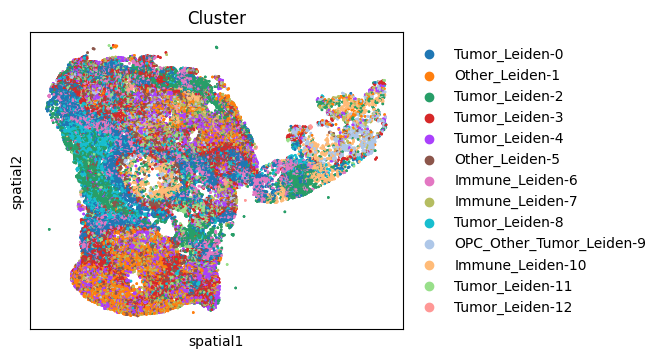

In [32]:
# Plot
sq.pl.spatial_scatter(adata, library_id="spatial", color=["Cluster"], shape=None)
plt.tight_layout()
plt.show()

C:\Users\jocke\AppData\Local\Temp\ipykernel_9996\3359327504.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


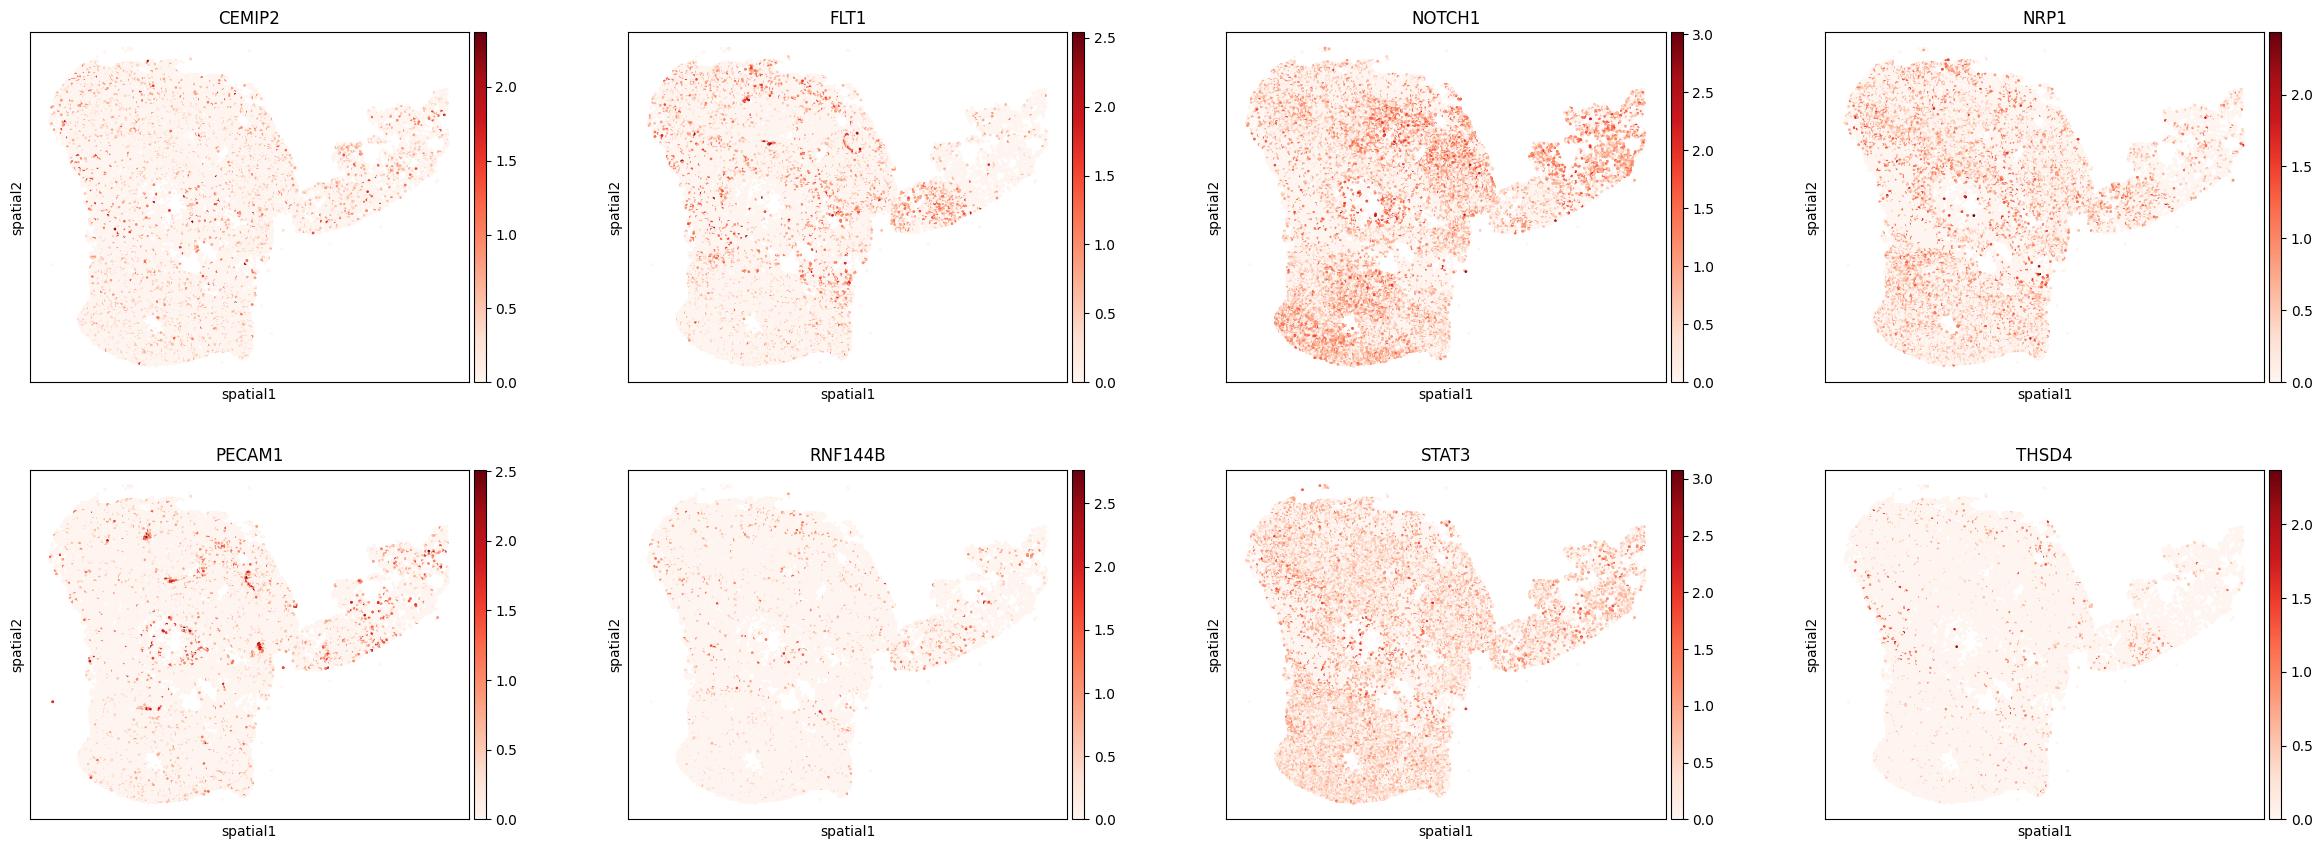

In [33]:
sq.pl.spatial_scatter(adata, library_id="spatial", color=["CEMIP2", "FLT1", "NOTCH1", "NRP1", "PECAM1", "RNF144B",
                                                          "STAT3", "THSD4"], shape=None, cmap="Reds")
plt.tight_layout()
plt.show()

#### **6. Downstream analysis**

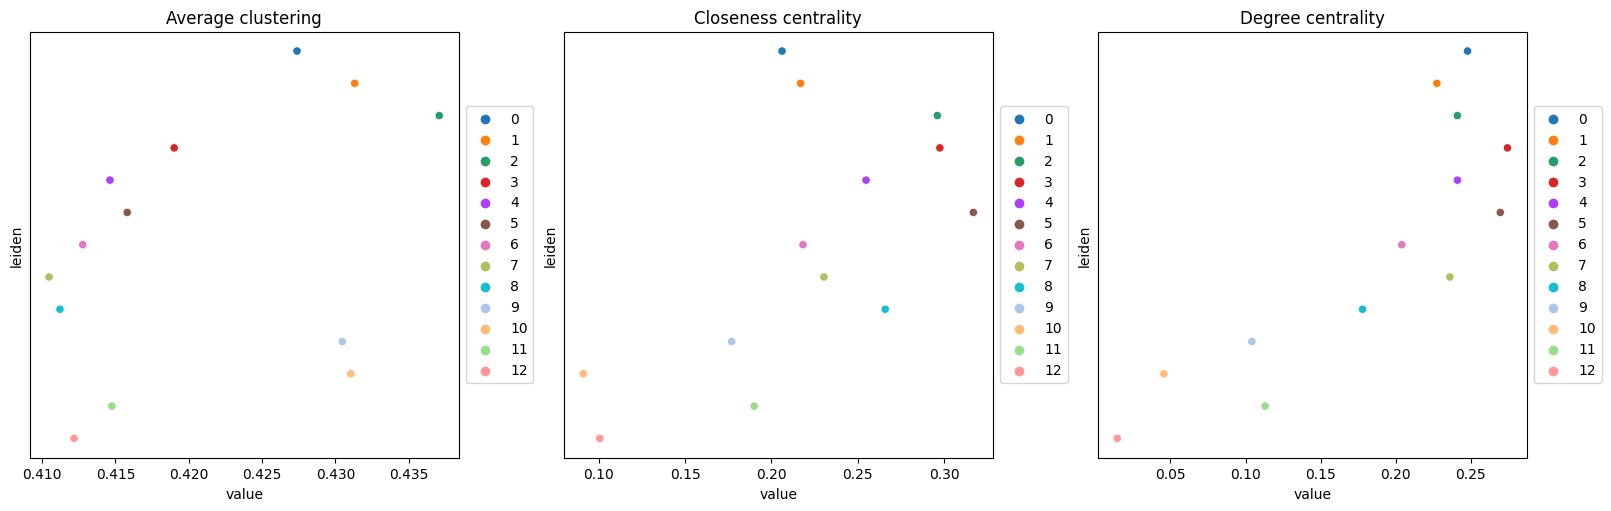

In [35]:
# Building the spatial neighbors graphs
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
# Compute centrality scores
sq.gr.centrality_scores(adata, cluster_key="leiden")
sq.pl.centrality_scores(adata, cluster_key="leiden", figsize=(16, 5))
plt.show()

  0%|          | 0/1 [00:00<?, ?/s]

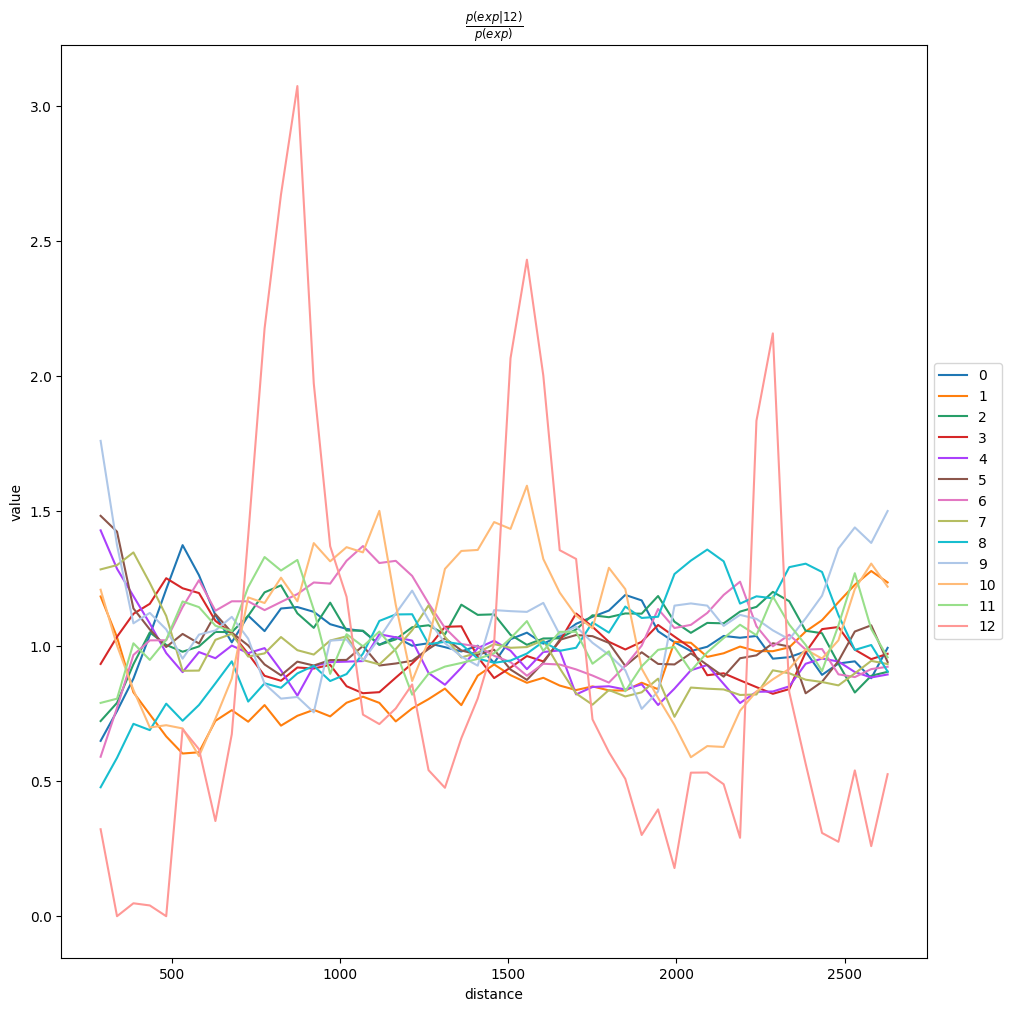

In [39]:
# Compute co-occurrence probability
adata_subsample = sc.pp.subsample(adata, fraction=0.5, copy=True)
sq.gr.co_occurrence(adata_subsample, cluster_key="leiden")
sq.pl.co_occurrence(adata_subsample, cluster_key="leiden", clusters="12", figsize=(10, 10))

  0%|          | 0/1000 [00:00<?, ?/s]

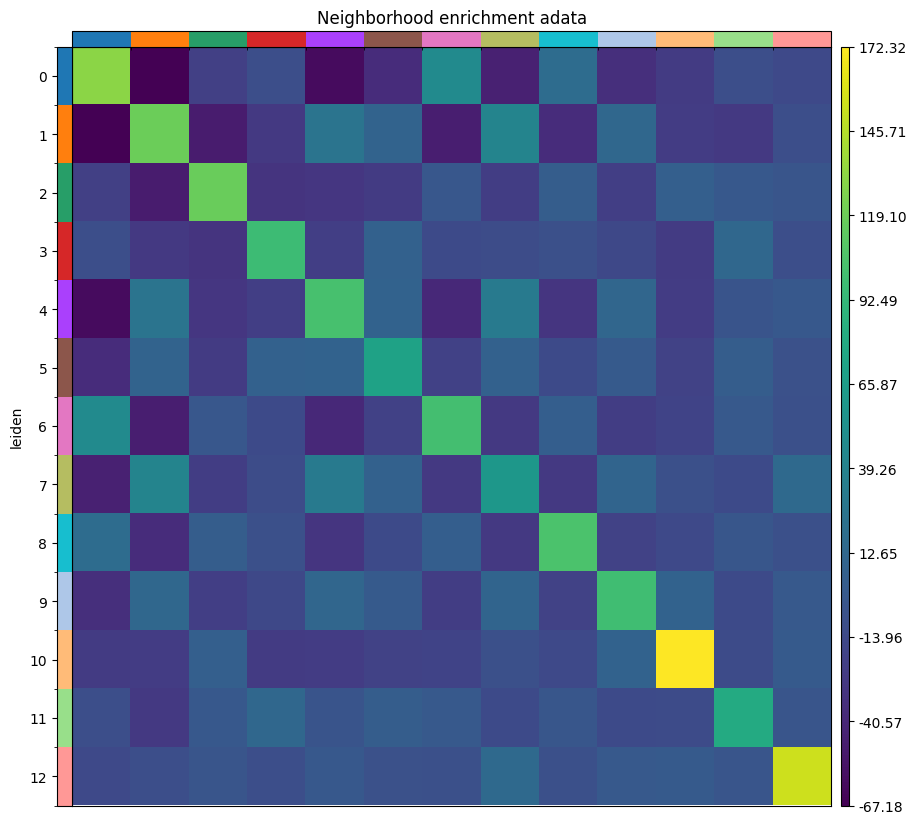

In [41]:
# Neighbors enrichment analysis
sq.gr.nhood_enrichment(adata, cluster_key="leiden")
sq.pl.nhood_enrichment(adata, cluster_key="leiden", figsize=(8, 8), title="Neighborhood enrichment adata")

##### Compute Moran'sI
The Moran’s I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.

In [42]:
sq.gr.spatial_neighbors(adata_subsample, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(adata_subsample, mode="moran", n_perms=100, n_jobs=1)
target_genes = adata_subsample.uns["moranI"].head(10).index

  0%|          | 0/100 [00:00<?, ?/s]

In [43]:
print(target_genes)

Index(['VEGFA', 'HILPDA', 'IGFBP5', 'IGFBP3', 'S100A8', 'S100A9', 'CHI3L1',
       'CXCL8', 'PTPRZ1', 'ADM'],
      dtype='object')


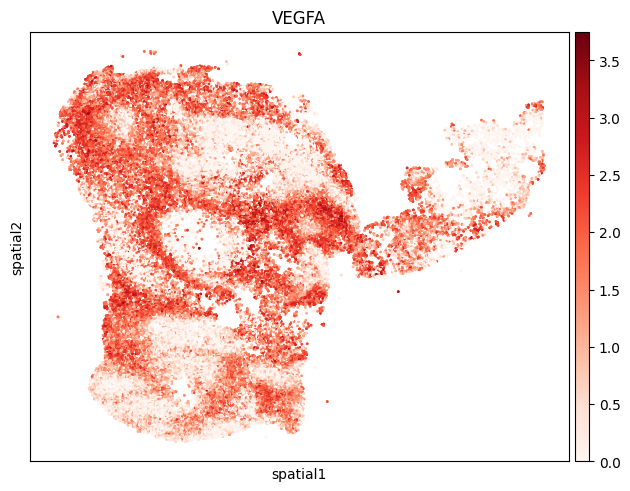

In [45]:
sq.pl.spatial_scatter(adata, color=["VEGFA"], shape=None, cmap="Reds")